Initial Dataset Loading

In [ ]:
#pip install resampy

In [ ]:
#pip install pysoundfile

In [2]:
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import pyaudio
import socket
import sys
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import soundfile as sf
import io
import threading
from keras.models import load_model

In [3]:
# Define the path to the main dataset directory containing 'fold1' to 'fold10'
dataset_dir = r'C:\Users\Paul\Downloads\Masters\MSc_DA_CA3\UrbanSound8K\UrbanSound8K\audio'


In [4]:

# Create extract_features() function
# This function will extract features from a single sound file, such as the MFCCs.
# It takes 1 parameter:
#     file_name: the path to the sound file
# It returns 1 value:
#     features: a numpy array of sound features

def extract_features(file_path, metadata):
    # Extract the class label based on the file name
    file_name = os.path.basename(file_path)
    class_label = metadata[metadata['slice_file_name'] == file_name]['class'].values[0]

    # Load the audio file
    audio, _ = librosa.load(file_path, res_type='kaiser_fast')

    # Extract features (e.g., Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)

    # Flatten the feature matrix
    mfccs = np.mean(mfccs.T, axis=0)

    return mfccs, class_label


In [5]:
# Create an empty list of features and labels
feature_list = []
label_list = []

In [18]:
# Get the list of folders in the main dataset directory
 # THIS WILL TAKE 7 MINS TO RUN 
for folder in os.listdir(dataset_dir):
    if folder.startswith('fold'):
        folder_path = os.path.join(dataset_dir, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                features, class_label = extract_features(file_path, metadata)
                feature_list.append(features)
                label_list.append(class_label)


c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [19]:
# Save Envirnmental Sound Classification features and labels to disk
np.save('features.npy', feature_list)
np.save('labels.npy', label_list)

In [6]:
# Load features and labels (to save time during development)
features = np.load('features.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

EDA

In [7]:
# Examine the size of the feature list
print('Number of feature vectors:', len(feature_list))

Number of feature vectors: 0


In [8]:
# Are the feature vectors all the same size?
print('Feature vector length:', len(feature_list[0]))

IndexError: list index out of range

In [8]:
# perform a t-test to see if the means of the feature vectors for two classes are significantly different
# Define two classes to compare
class_1 = 'children_playing'
class_2 = 'dog_bark'

# Get the list of class labels
class_labels = list(set(label_list))

# Get the list of feature vectors for each class
class_1_features = [feature_list[i] for i in range(len(feature_list)) if label_list[i] == class_1]

class_2_features = [feature_list[i] for i in range(len(feature_list)) if label_list[i] == class_2]

# Perform t-test
t, p = ttest_ind(class_1_features, class_2_features)

# Print the results of the t-test
print('t = ' + str(t))
print('p = ' + str(p))

# Create a Pandas DataFrame to hold the feature vectors and class labels
features_df = pd.DataFrame(features)
features_df['class'] = labels

# Examine the DataFrame
features_df.head()

# Examine the distribution of class labels
features_df['class'].value_counts()

t = nan
p = nan


dog_bark            1000
jackhammer          1000
engine_idling       1000
children_playing    1000
street_music        1000
air_conditioner     1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [9]:
# Add feature names to DataFrame
feature_names = ['mfcc' + str(i) for i in range(1, 14)]
feature_names.append('class')
features_df.columns = feature_names

# Examine the DataFrame
features_df.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,class
0,-403.450775,93.772453,17.812965,-11.735518,-7.220359,3.765296,-16.174644,-6.859319,-10.542679,-5.188827,0.041710,-4.935716,0.938063,dog_bark
1,-367.814758,128.261002,29.322836,-21.599026,-14.891522,2.339720,-28.616245,-17.765814,-23.516216,-8.776717,1.006966,-4.489775,4.392671,dog_bark
2,-422.120544,69.941666,9.877000,0.094108,1.648382,3.525948,-9.561525,-1.859950,-3.891847,-0.314790,3.337800,0.717791,-1.352891,dog_bark
3,-259.886444,107.981140,-50.568455,-5.474560,-17.245996,1.901729,-6.068827,6.973870,0.355850,12.182370,-0.023248,24.034210,-4.974939,dog_bark
4,-386.498505,131.816086,26.007700,22.088737,-9.809354,3.992721,-6.131800,8.991668,-0.286275,7.668528,-4.322468,2.864880,0.418705,gun_shot


In [10]:
# Create a list of meaningful column names based on MFCC descriptions
mfcc_column_names = [
    'mfcc_energy',
    'mfcc_spectral_low1',
    'mfcc_spectral_mid1',
    'mfcc_spectral_mid2',
    'mfcc_spectral_mid3',
    'mfcc_spectral_high1',
    'mfcc_spectral_high2',
    'mfcc_spectral_high3',
    'mfcc_spectral_high4',
    'mfcc_spectral_high5',
    'mfcc_detail1',
    'mfcc_detail2',
    'mfcc_detail3',
    'class'
]

# Assign the created column names to the features DataFrame
features_df.columns = mfcc_column_names

                fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.839398     1.000000     3.000000   
50%    118279.000000    10.376492    14.000000     1.000000     5.000000   
75%    166942.000000    35.131372    38.866979     2.000000     8.000000   
max    209992.000000   600.125356   604.125356     2.000000    10.000000   

           classID  
count  8732.000000  
mean      4.592877  
std       2.894544  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       7.000000  
max       9.000000  
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0


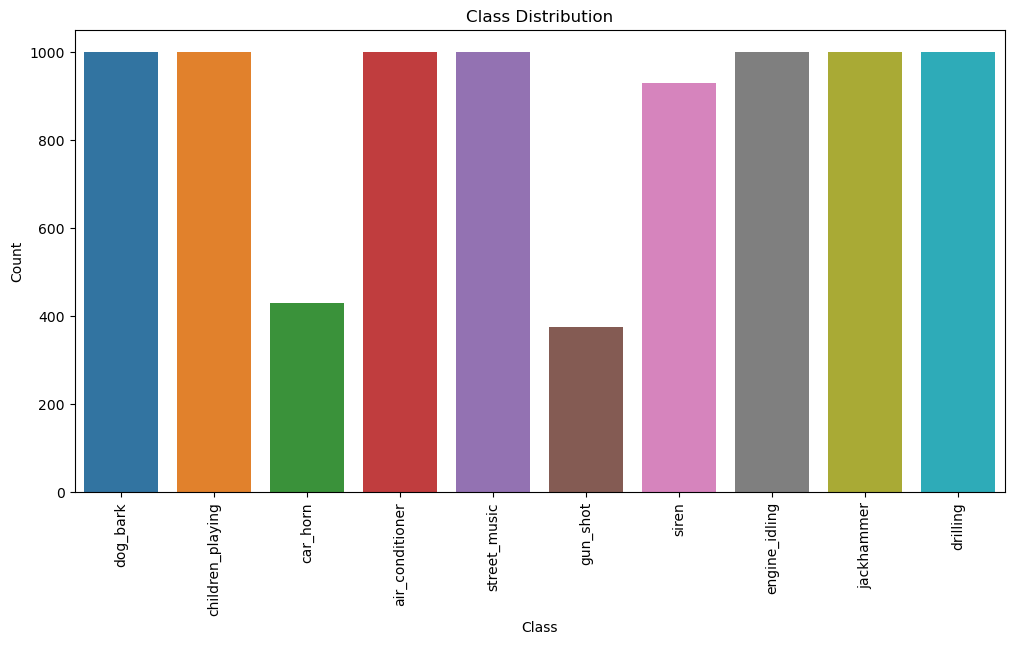

       mfcc_energy  mfcc_spectral_low1  mfcc_spectral_mid1  \
count  8732.000000         8732.000000         8732.000000   
mean   -230.184631          114.321854          -27.656820   
std     129.707123           48.001690           31.378609   
min    -766.317749          -64.599388         -165.692215   
25%    -313.787605           86.691669          -44.714517   
50%    -217.100456          120.122486          -24.517739   
75%    -131.428020          147.059368           -8.226402   
max     129.532166          276.579529           83.811600   

       mfcc_spectral_mid2  mfcc_spectral_mid3  mfcc_spectral_high1  \
count         8732.000000         8732.000000          8732.000000   
mean            20.384014          -12.987039            14.454811   
std             21.766222           15.723857            14.681323   
min            -79.691612          -99.794167           -58.930050   
25%              9.304368          -23.082563             6.195792   
50%             23.09

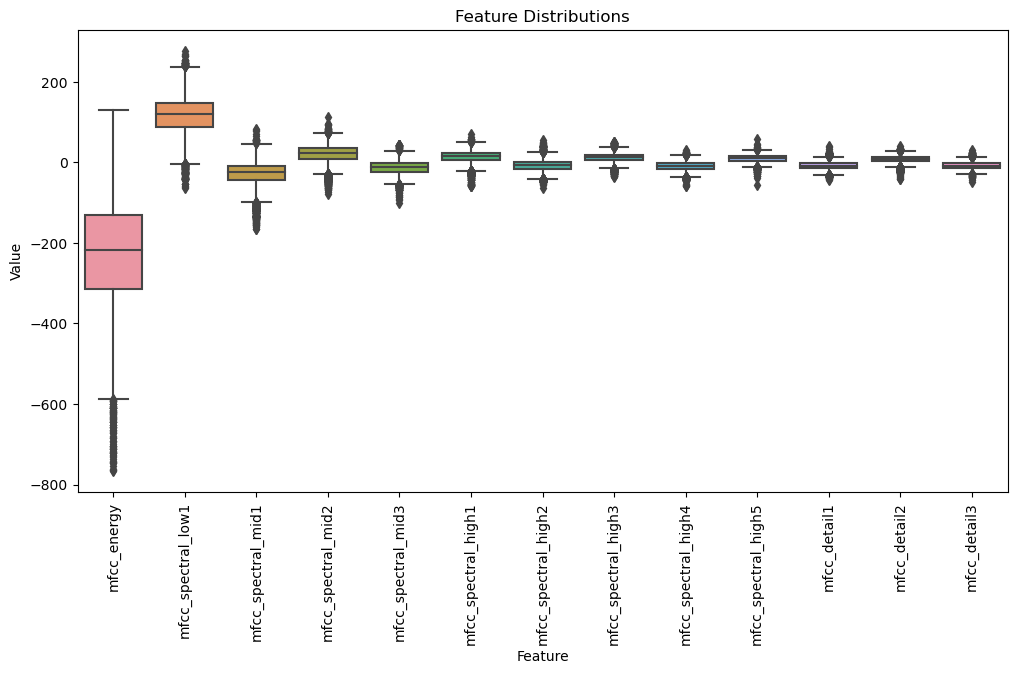

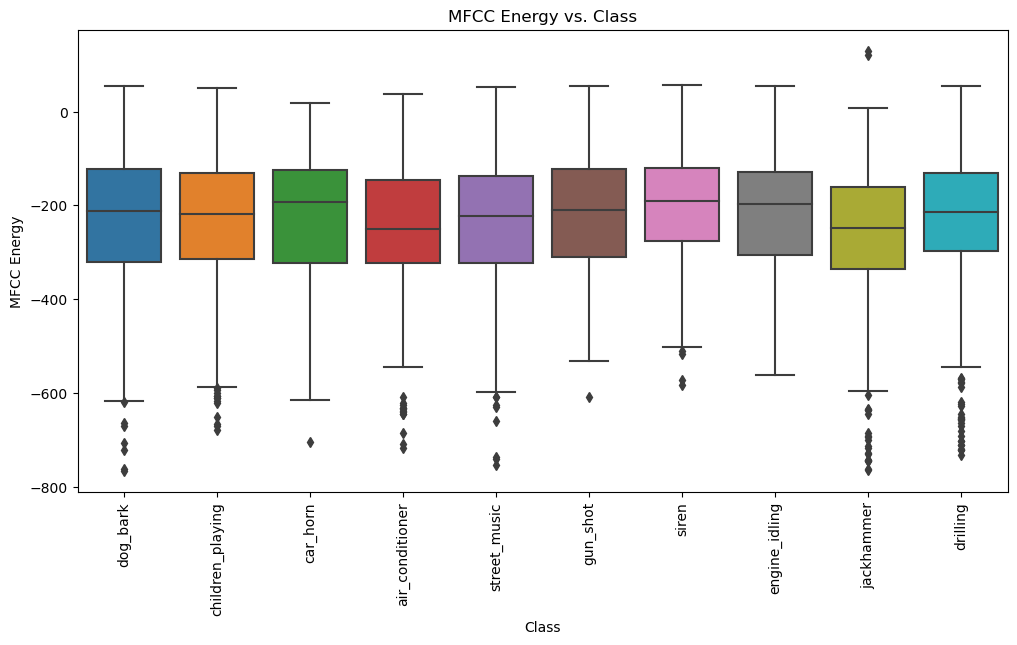

Test for class dog_bark: t-statistic=0.36192885328845226, p-value=0.7174139576060821
Test for class children_playing: t-statistic=0.3428966815776828, p-value=0.7316844442872972
Test for class car_horn: t-statistic=1.3675435720991733, p-value=0.17149019422392164
Test for class air_conditioner: t-statistic=-4.046567321229036, p-value=5.2422395017633404e-05
Test for class street_music: t-statistic=-2.674581050148306, p-value=0.007496209967690917
Test for class gun_shot: t-statistic=2.101028221427894, p-value=0.03566708602241529
Test for class siren: t-statistic=7.137707769257521, p-value=1.0248855524025598e-12
Test for class engine_idling: t-statistic=3.756710587912719, p-value=0.00017328188220103283
Test for class jackhammer: t-statistic=-7.317773855783848, p-value=2.7443525119233534e-13
Test for class drilling: t-statistic=0.3984356822897764, p-value=0.6903188038090458


In [11]:
# Load the CSV file with metadata
metadata = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8k.csv')

# Display basic statistics about the dataset
print(metadata.describe())

# Check for missing values
print(metadata.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='class')
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display basic statistics about the features
print(features_df.describe())

# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_df.drop(columns=['class']))
plt.title('Feature Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

# Explore relationships between features and class labels
merged_data = pd.concat([features_df.drop(columns=['class']), metadata['class']], axis=1)
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='class', y='mfcc_energy')  
plt.title('MFCC Energy vs. Class')
plt.xlabel('Class')
plt.ylabel('MFCC Energy')
plt.xticks(rotation=90)
plt.show()

# Perform statistical tests (e.g., t-tests or ANOVA) to assess feature significance
from scipy.stats import ttest_ind

class_labels = metadata['class'].unique()
for label in class_labels:
    group1 = features_df[metadata['class'] == label]['mfcc_energy']
    group2 = features_df[metadata['class'] != label]['mfcc_energy']
    t_stat, p_value = ttest_ind(group1, group2)
    print(f'Test for class {label}: t-statistic={t_stat}, p-value={p_value}')


In [12]:
# Perform Anova tests to list classes that are significantly different from each other

# Define the significance level
alpha = 0.05

class_labels = metadata['class'].unique()

for mfcc_column_name in mfcc_column_names:
    print(f"Testing significance for feature column: {mfcc_column_name}")
    for label in class_labels:
        group1 = features_df[metadata['class'] == label][mfcc_column_name]
        group2 = features_df[metadata['class'] != label][mfcc_column_name]
        t_stat, p_value = ttest_ind(group1, group2)
        if p_value < alpha:
            print(f'Test for class {label}: t-statistic={t_stat}, p-value={p_value}') # Reject null hypothesis
    print("\n")

Testing significance for feature column: mfcc_energy
Test for class air_conditioner: t-statistic=-4.046567321229036, p-value=5.2422395017633404e-05
Test for class street_music: t-statistic=-2.674581050148306, p-value=0.007496209967690917
Test for class gun_shot: t-statistic=2.101028221427894, p-value=0.03566708602241529
Test for class siren: t-statistic=7.137707769257521, p-value=1.0248855524025598e-12
Test for class engine_idling: t-statistic=3.756710587912719, p-value=0.00017328188220103283
Test for class jackhammer: t-statistic=-7.317773855783848, p-value=2.7443525119233534e-13


Testing significance for feature column: mfcc_spectral_low1
Test for class dog_bark: t-statistic=-2.5122938309291096, p-value=0.012012803433766601
Test for class car_horn: t-statistic=-2.831892669453514, p-value=0.004637928784580187
Test for class air_conditioner: t-statistic=2.6064278970888974, p-value=0.00916475428894602
Test for class street_music: t-statistic=-2.252410770307752, p-value=0.02432106231411

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Sound Classfication Model

Epoch 1/50
175/175 - 1s - loss: 10.9629 - accuracy: 0.1505 - val_loss: 2.2566 - val_accuracy: 0.1389 - 1s/epoch - 7ms/step
Epoch 2/50
175/175 - 0s - loss: 2.4239 - accuracy: 0.1594 - val_loss: 2.2347 - val_accuracy: 0.1417 - 369ms/epoch - 2ms/step
Epoch 3/50
175/175 - 0s - loss: 2.2727 - accuracy: 0.1747 - val_loss: 2.1904 - val_accuracy: 0.1611 - 366ms/epoch - 2ms/step
Epoch 4/50
175/175 - 0s - loss: 2.1872 - accuracy: 0.2022 - val_loss: 2.1083 - val_accuracy: 0.2040 - 401ms/epoch - 2ms/step
Epoch 5/50
175/175 - 0s - loss: 2.1440 - accuracy: 0.2144 - val_loss: 2.0152 - val_accuracy: 0.2606 - 447ms/epoch - 3ms/step
Epoch 6/50
175/175 - 0s - loss: 2.1090 - accuracy: 0.2283 - val_loss: 1.9688 - val_accuracy: 0.2527 - 414ms/epoch - 2ms/step
Epoch 7/50
175/175 - 0s - loss: 2.0709 - accuracy: 0.2310 - val_loss: 1.9406 - val_accuracy: 0.2899 - 415ms/epoch - 2ms/step
Epoch 8/50
175/175 - 1s - loss: 2.0367 - accuracy: 0.2529 - val_loss: 1.9009 - val_accuracy: 0.2835 - 511ms/epoch - 3ms/step
Ep

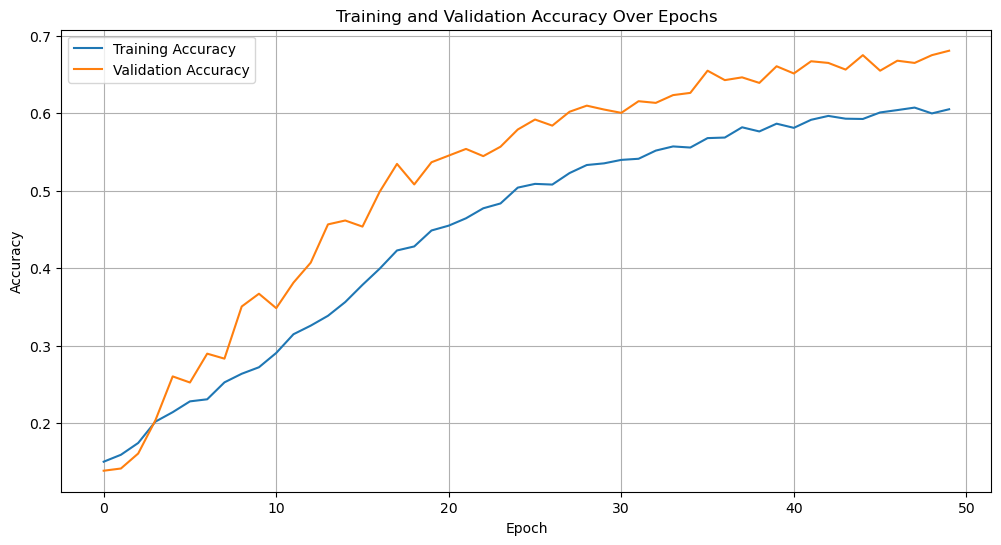

In [41]:
# Convert lists to NumPy arrays
X = np.array(feature_list)
y = np.array(label_list)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the deep learning model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode class labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Create a confusion matrix and classification report
confusion = confusion_matrix(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# Save the model
model.save('UrbanSound8K_model.h5')

print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

c:\Users\Paul\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Fold 1:
Training Loss: 0.7052
Training Accuracy: 0.7721
Testing Loss: 0.7760
Testing Accuracy: 0.7460
----------------------------------------
Fold 2:
Training Loss: 0.7273
Training Accuracy: 0.7718
Testing Loss: 0.7866
Testing Accuracy: 0.7529
----------------------------------------
Fold 3:
Training Loss: 0.6957
Training Accuracy: 0.7757
Testing Loss: 0.8183
Testing Accuracy: 0.7136
----------------------------------------
Fold 4:
Training Loss: 0.6886
Training Accuracy: 0.7739
Testing Loss: 0.7713
Testing Accuracy: 0.7491
----------------------------------------
Fold 5:
Training Loss: 0.7172
Training Accuracy: 0.7731
Testing Loss: 0.7311
Testing Accuracy: 0.7595
----------------------------------------
Fold 6:
Training Loss: 0.6993
Training Accuracy: 0.7776
Testing Loss: 0.7359
Testing Accuracy: 0.7617
----------------------------------------
Fold 7:
Training Loss: 0.7036
Training Accuracy: 0.7748
Testing Loss: 0.8259
Testing Accuracy: 0.7514
----------------------------------------

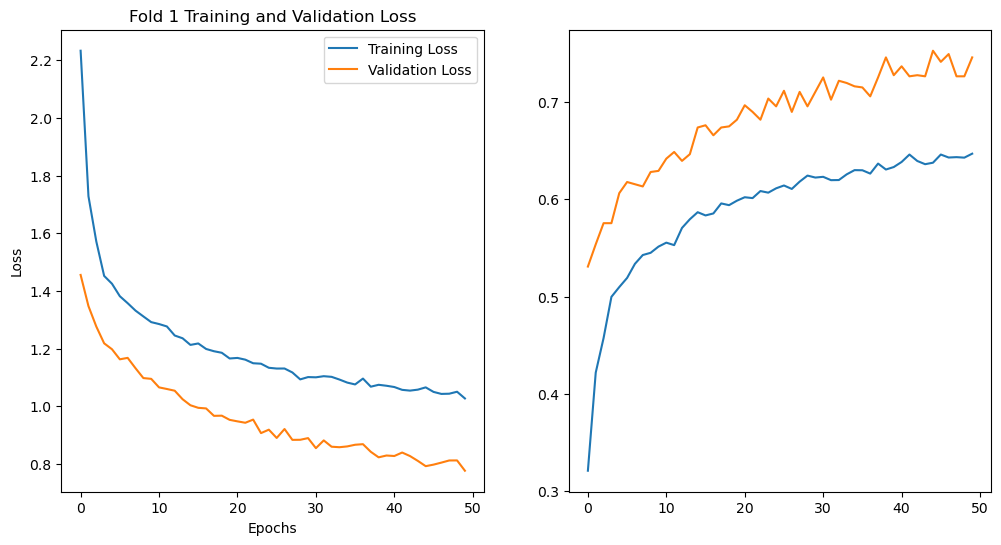

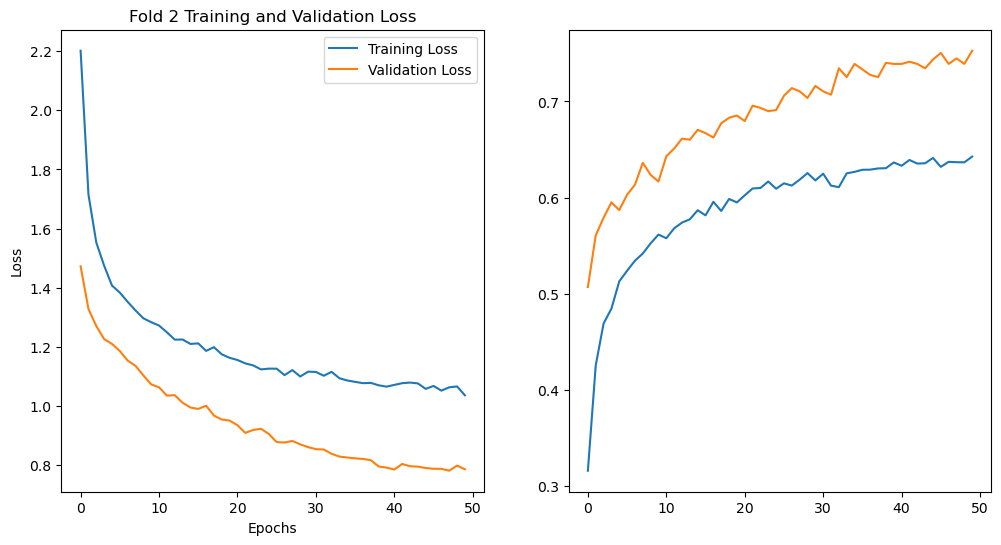

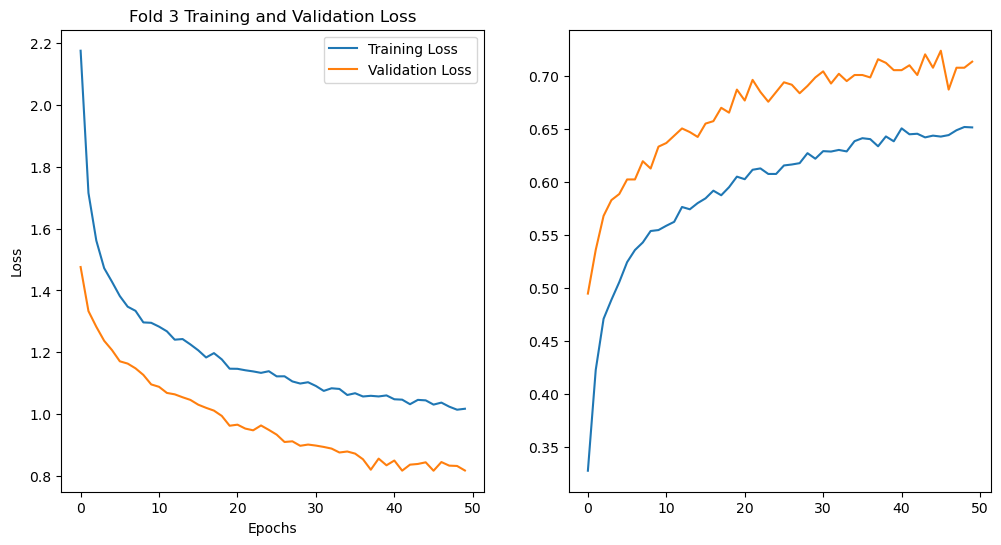

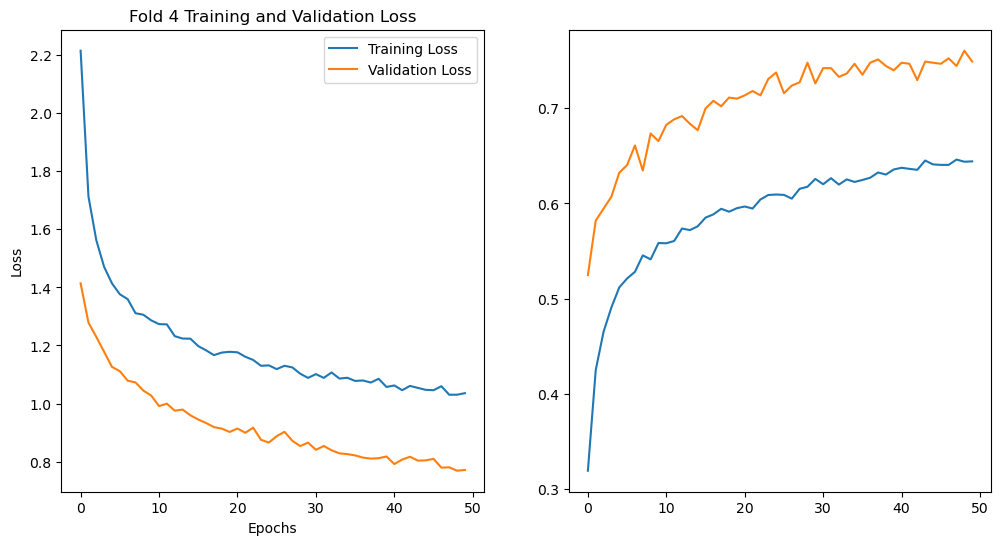

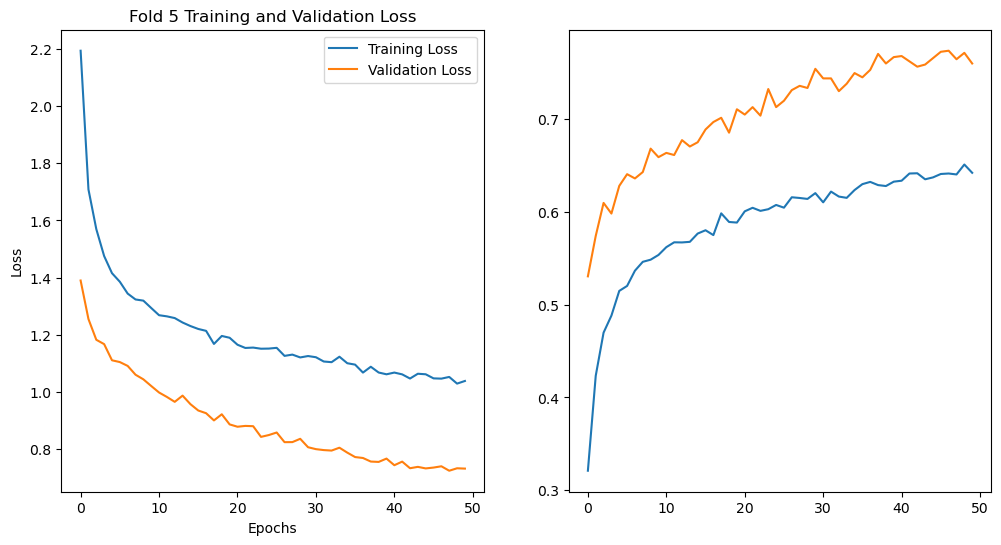

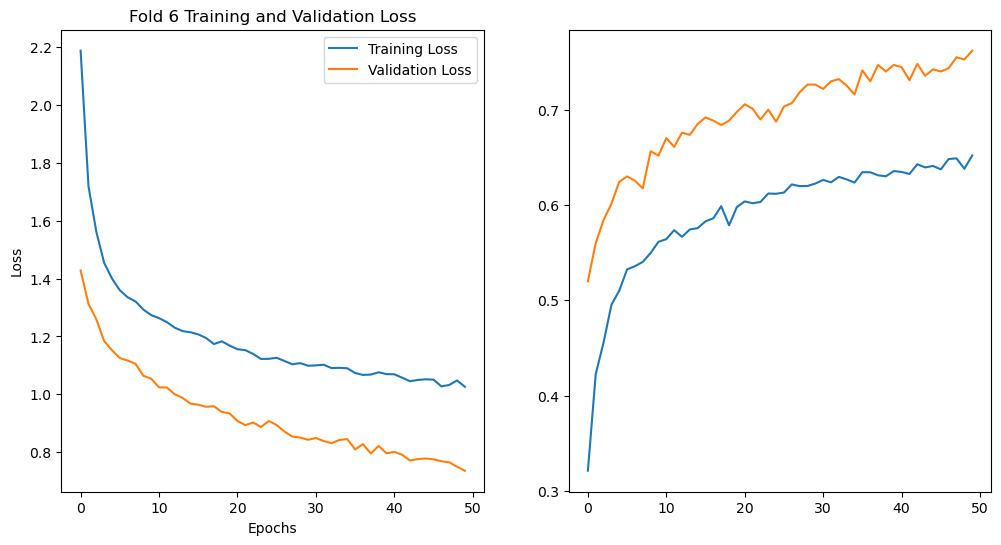

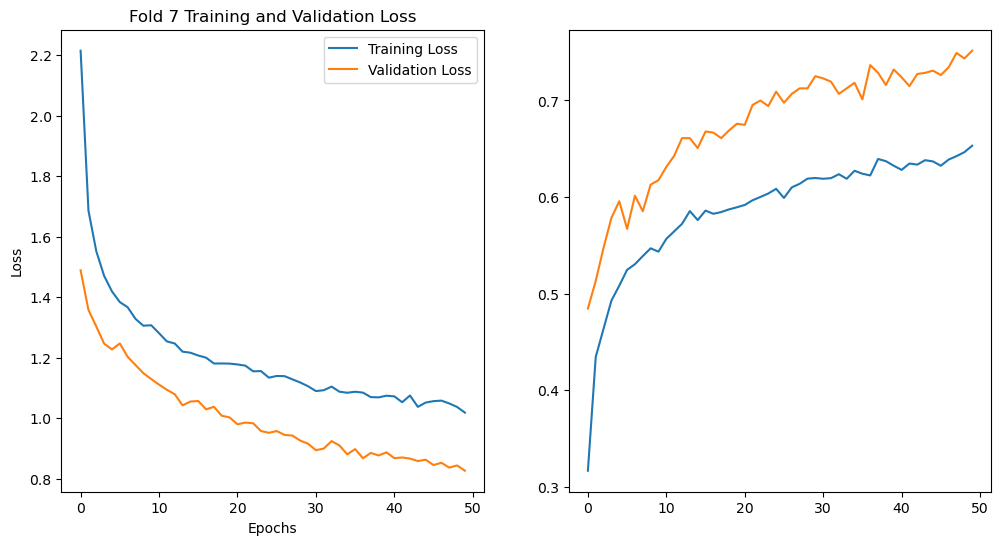

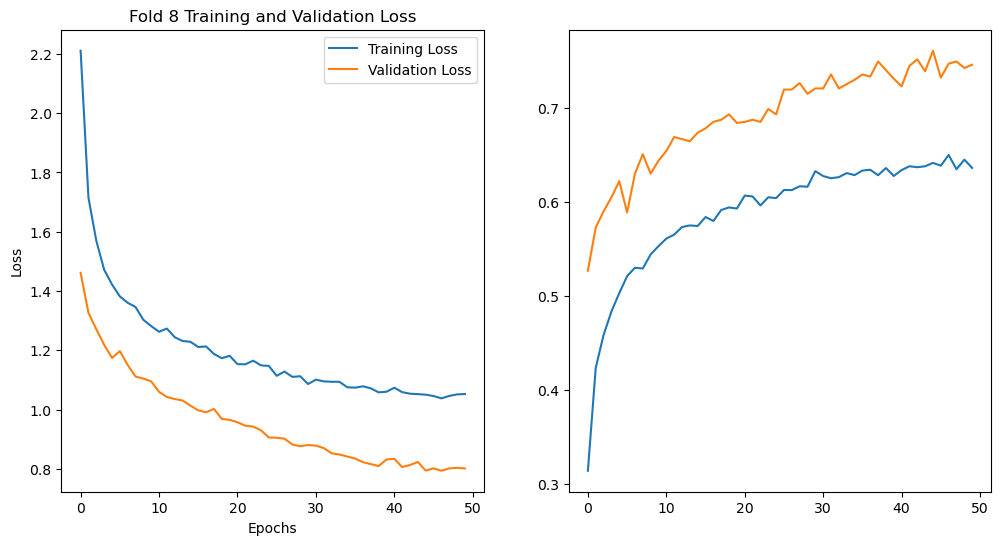

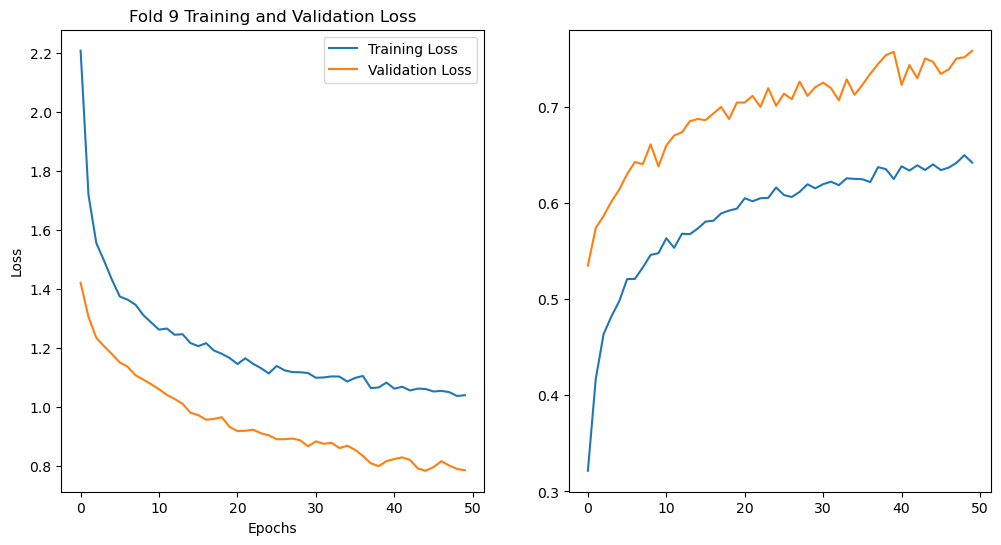

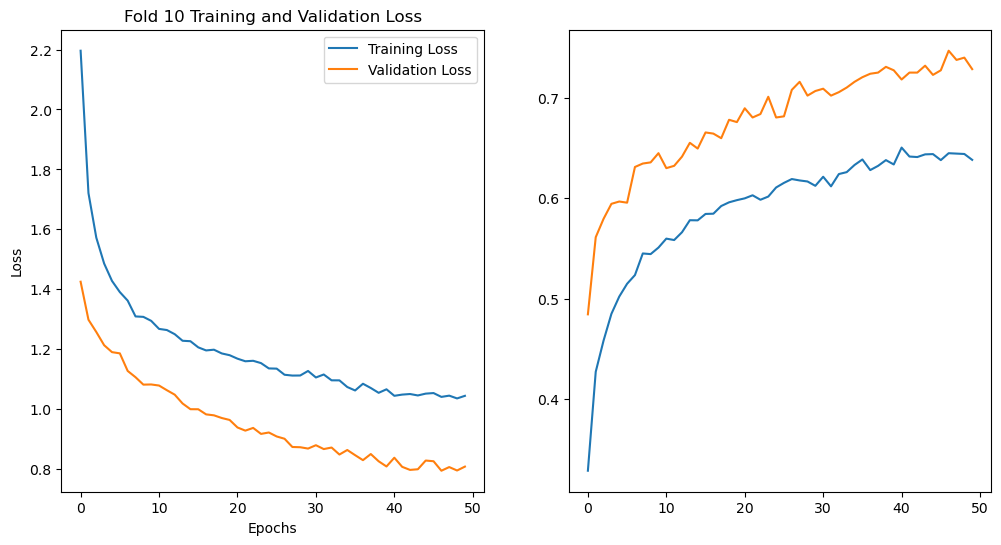

In [43]:
# Convert the label list to numpy array
#labels = np.array(label_list)

# Encode class labels to integers
labelsfit = label_encoder.fit_transform(labels)

# Define the number of folds
n_folds = 10

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store results for each fold
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Iterate through each fold
for fold_idx, (train_index, test_index) in enumerate(kf.split(np.array(feature_list), labelsfit), start=1):
    X_train, X_test = np.array(feature_list)[train_index], np.array(feature_list)[test_index]
    y_train, y_test = labelsfit[train_index], labelsfit[test_index]

    # Build and compile the model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on both training and testing sets for this fold
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # Save the model
    model.save(f'UrbanSound8K_fold{fold_idx}.h5')
    
    # Print out the fold number and results
    print(f'Fold {fold_idx}:')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Training Accuracy: {train_accuracy:.4f}')
    print(f'Testing Loss: {test_loss:.4f}')
    print(f'Testing Accuracy: {test_accuracy:.4f}')
    print('-' * 40)

    # Plot training history for each fold
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_idx} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title

Streaming Audio Classification

In [63]:
# Create a SparkContext
sc = SparkContext("local[2]", "SoundClassificationApp")
sc.setLogLevel("ERROR")

# Initialize Spark StreamingContext
batch_duration = 1
ssc = StreamingContext(sc, batch_duration)

# Define a function to process incoming audio data
def process_audio_data(rdd):
    audio_data = rdd.collect()
    if audio_data:
        # Combine audio data from all batches
        combined_audio = b''.join(audio_data)

        # Process the combined audio data (e.g., feature extraction)
        # Example: Save the audio data to a file
        audio_path = 'received_audio.wav'
        sf.write(audio_path, np.frombuffer(combined_audio, dtype=np.int16), 44100)

# Create a DStream from the network socket
audio_stream = ssc.socketTextStream("localhost", 9999)

# Process incoming audio data
audio_stream.foreachRDD(process_audio_data)

# Function to stop Spark Streaming after a specified duration
def stop_streaming():
    print("Stopping Spark Streaming after 15 seconds...")
    ssc.stop(stopSparkContext=False, stopGraceFully=True)

# Start the Spark Streaming context
ssc.start()

# Schedule the stop_streaming function to run after 15 seconds
stop_timer = threading.Timer(15.0, stop_streaming)
stop_timer.start()

# Await termination
ssc.awaitTermination()


c:\Users\Paul\anaconda3\lib\site-packages\pyspark\streaming\context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


Stopping Spark Streaming after 8 seconds...


In [ ]:
# Define audio settings
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

# Create a PyAudio object
p = pyaudio.PyAudio()

# Create a socket connection to the Spark Streaming application
host = 'localhost'  
port = 9999         
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host, port))

try:
    print("Streaming audio. Press Ctrl+C to stop.")
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    while True:
        audio_data = stream.read(CHUNK)
        s.sendall(audio_data)

except KeyboardInterrupt:
    print("Stopping audio stream.")
    stream.stop_stream()
    stream.close()
    p.terminate()
    s.close()
    sys.exit(0)


In [81]:
sc.stop()  # Shutdown the existing SparkContext
ssc.stop() # Shutdown the existing StreamingContext

In [ ]:
import threading
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

# Create a SparkContext
sc = SparkContext("local[2]", "SoundClassificationApp")
sc.setLogLevel("ERROR")

# Initialize Spark StreamingContext
batch_duration = 1
ssc = StreamingContext(sc, batch_duration)

# Define a function to process incoming audio data
def process_audio_data(rdd):
    audio_data = rdd.collect()
    if audio_data:
        # Combine audio data from all batches
        combined_audio = b''.join(audio_data)

        # Process the combined audio data (e.g., feature extraction)
        # Example: Save the audio data to a file 
        audio_path = 'received_audio.wav'
        sf.write(audio_path, np.frombuffer(combined_audio, dtype=np.int16), 44100)

# Create a DStream from the network socket
audio_stream = ssc.socketTextStream("localhost", 9999)

# Process incoming audio data
audio_stream.foreachRDD(process_audio_data)

# Function to stop Spark Streaming after a specified duration
def stop_streaming():
    print("Stopping Spark Streaming after 15 seconds...")
    ssc.stop(stopSparkContext=False, stopGraceFully=True)

# Start the Spark Streaming context
ssc.start()

# Schedule the stop_streaming function to run after 15 seconds
stop_timer = threading.Timer(15.0, stop_streaming)
stop_timer.start()

# Await termination
ssc.awaitTermination()

# Define audio settings
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

# Create a PyAudio object
p = pyaudio.PyAudio()

# Create a socket connection to the Spark Streaming application
host = 'localhost'  
port = 9999         
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host, port))

try:
    print("Streaming audio. Press Ctrl+C to stop.")
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    while True:
        audio_data = stream.read(CHUNK)
        s.sendall(audio_data)

except KeyboardInterrupt:
    print("Stopping audio stream.")
    stream.stop_stream()
    stream.close()
    p.terminate()
    s.close()
    sys.exit(0)


In [13]:
# Create a SparkContext
sc = SparkContext("local[2]", "SoundClassificationApp")
sc.setLogLevel("ERROR")

# Initialize Spark StreamingContext
batch_duration = 1
ssc = StreamingContext(sc, batch_duration)

# Define a function to process incoming audio data
def process_audio_data(rdd):
    audio_data = rdd.collect()
    if audio_data:
        # Combine audio data from all batches
        combined_audio = b''.join(audio_data)

        # Process the combined audio data (e.g., feature extraction)
        # Example: Save the audio data to a file 
        audio_path = 'received_audio.wav'
        sf.write(audio_path, np.frombuffer(combined_audio, dtype=np.int16), 44100)

# Create a DStream from the network socket
audio_stream = ssc.socketTextStream("localhost", 9999)

# Process incoming audio data
audio_stream.foreachRDD(process_audio_data)

# Function to stop Spark Streaming after a specified duration
def stop_streaming():
    print("Stopping Spark Streaming after 15 seconds...")
    ssc.stop(stopSparkContext=False, stopGraceFully=True)

# Schedule the stop_streaming function to run after 15 seconds
stop_timer = threading.Timer(15.0, stop_streaming)
stop_timer.start()

# Function to run the audio streaming part
def run_audio_streaming():
    import socket
    import pyaudio
    import sys

# Define audio settings
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

# Create a PyAudio object
p = pyaudio.PyAudio()

# Create a socket connection to the Spark Streaming application
host = 'localhost'  
port = 9999         
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((host, port))

try:
    print("Streaming audio. Press Ctrl+C to stop.")
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    while True:
        audio_data = stream.read(CHUNK)
        s.sendall(audio_data)

except KeyboardInterrupt:
    print("Stopping audio stream.")
    stream.stop_stream()
    stream.close()
    p.terminate()
    s.close()
    sys.exit(0)

# Create a thread for the audio streaming part
audio_thread = threading.Thread(target=run_audio_streaming)

# Start the Spark Streaming context
ssc.start()

# Start the audio streaming thread
audio_thread.start()

# Await termination for Spark Streaming
ssc.awaitTermination()

c:\Users\Paul\anaconda3\lib\site-packages\pyspark\streaming\context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AudioProcessing") \
    .getOrCreate()

# Read audio data from Kafka topic
audio_stream = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092")  # Update with your Kafka broker address
    .option("subscribe", "UrbanSounds")  # Kafka topic with audio data
    .load()

# Define processing logic (you can replace this with your audio processing logic)
def process_audio_data(audio_data):
    # Your audio processing code here
    return audio_data

# Apply the processing logic to the audio stream
processed_audio_stream = audio_stream.selectExpr("topic", "value as audio_data") \
    .withColumn("processed_audio", process_audio_data("audio_data"))

# Define output options (e.g., write results to another Kafka topic)
output_options = {
    "kafka.bootstrap.servers": "localhost:9092",  # Update with your Kafka broker address
    "topic": "processed_audio_topic"  # Kafka topic for processed audio data
}

# Write processed audio data to Kafka or another output sink
query = processed_audio_stream \
    .select("topic", "processed_audio") \
    .writeStream \
    .format("kafka") \
    .options(**output_options) \
    .start()

query.awaitTermination()


In [ ]:
import sounddevice as sd
import numpy as np
import kafka
from pyspark.sql import SparkSession

# Initialize Kafka producer for writing classified audio data
producer = kafka.KafkaProducer(bootstrap_servers='localhost:9092')

# Create a SparkSession
spark = SparkSession.builder \
    .appName("AudioProcessing") \
    .getOrCreate()
    
model = load_model('UrbanSound8K_model.h5')

# Define a function to process and classify audio data
def process_and_classify_audio(audio_data):
    # Load the pre-trained neural network model (UrbanSound8K_model.h5)
    # Replace this with your actual model loading code
    # Example: model = load_model('UrbanSound8K_model.h5')

    # Process and classify audio data using the loaded model
    # Example: predicted_class = model.predict_classes(np.array([audio_data]))[0]

    # Send the classified result to a Kafka topic (e.g., "classified_audio")
    producer.send("classified_audio", value=predicted_class.encode('utf-8'))

# Start recording audio using sounddevice
def audio_callback(indata, frames, time, status):
    if status:
        print(status, flush=True)
    else:
        # Process and classify the recorded audio
        process_and_classify_audio(indata)

# Define audio settings
CHUNK = 1024
FORMAT = np.int16
CHANNELS = 1
RATE = 44100

# Create a PyAudio object for audio recording
audio_stream = sd.InputStream(callback=audio_callback, channels=CHANNELS, samplerate=RATE)

# Start recording audio
with audio_stream:
    # Read audio data from the microphone and process/classify it in real-time
    while True:
        pass  # The audio_callback function will handle audio processing and classification

# Wait indefinitely to keep the Spark Structured Streaming application running
spark.streams.awaitAnyTermination()